In [8]:
using LCIO
using GRUtils
using StatsBase
using JuliaDB
using IterableTables
using DataFrames
using LinearAlgebra

In [9]:
#tabulate higgs branching ratios (and associoated error) using countmap - I might revisit this later
strangemomenta = []
totalparticlearray = []
total_events = 0
LCIO.open("E250-TDR_ws.Pe2e2h.Gwhizard-1_95.eL.pR.I106479.001.slcio") do reader
    number_events = 0
    for event in reader
        higgsparticlelist = []
        number_events+=1
        for particle in getCollection(event, "MCParticle")
            
            parent = [p for p in getParents(particle)[]]
            parentPDG=0
            #println("here")
            if length(parent) > 0
                parentPDG = getPDG(parent[1])
            end
            #println("parentPDG equals $(parentPDG)")
            if parentPDG == 25 && getPDG(particle)!= 25 
                push!(totalparticlearray,abs(getPDG(particle)))
                if getPDG(particle)==3 || getPDG(particle) == -3
                    push!(strangemomenta,norm(getMomentum(particle)))
                end
            end
        end
    end
    total_events = number_events
    #println(total_events)
    x=countmap(totalparticlearray)
    #println("The total particle distribution: ", x)
    y = size(totalparticlearray)[1]
    println(y)
    newdict = Dict()
    for (key,value) in x
        newdict[key] = value/y
    end
    #println(newdict)
    PDGValues = []
    Prob = []
    for (key,value) in newdict
        push!(PDGValues, key)
        push!(Prob,(value, sqrt(value*y)/total_events))
    end

    df = DataFrame(x = PDGValues, y = Prob)
    table(df)
end


34286


Table with 9 rows, 2 columns:
x   y
──────────────────────────────
23  (0.0270664, 0.001777)
4   (0.0267748, 0.0017674)
13  (0.000233331, 0.00016499)
24  (0.214432, 0.00500168)
3   (0.000466663, 0.000233331)
5   (0.582862, 0.00824621)
22  (0.00250831, 0.000540957)
21  (0.0819577, 0.00309219)
15  (0.0636995, 0.00272609)

In [10]:
#tabulate charm quark decays (whether its a strange hadron or not, this code is better implemented in the momentum_histograms file)

#find all hadrons (stable or unstable) who come originally from higgs to charm decay

totalMomenta = []
function findHadrons2(particle)
    total_list = []
    daughter_list = [p for p in getDaughters(particle)[]]
    if getPDG(particle)>99
        push!(total_list,(getPDG(particle),norm(getMomentum(particle)), getGeneratorStatus(particle)))
    end
    if length(daughter_list)==0
        return total_list
    end
    for x in daughter_list
        if getGeneratorStatus(x)==1 && getPDG(x)>99
            #println("here")
            push!(total_list,(getPDG(x),norm(getMomentum(x)), getGeneratorStatus(x)))
        else
            return findHadrons2(x)
        end
    end
    return total_list
end

#find strange hadrons
function findstrange(count_dict,len)
    println(len)
    total_strange = 0
    strange_mesons = 0
    strange_baryons = 0
    other_strange = 0
    other = 0
    for (key,value) in count_dict
        key_string = string(abs(key))
        if key_string[1]=='3' || key_string == "130"
            total_strange+=value
            if length(key_string)==3
                strange_mesons+=value
            elseif length(key_string)==4
                strange_baryons+=value
            else
                other_strange+=value
            end
        end
    end
    other = len - total_strange
    stringlist = ["strange hadrons","strange mesons","strange baryons","other_strange","other particles"]
    problist = []
    push!(problist,(total_strange,sqrt(total_strange)))
    push!(problist,(strange_mesons,sqrt(strange_mesons)))
    push!(problist,(strange_baryons,sqrt(strange_baryons)))
    push!(problist,(other_strange,sqrt(other_strange)))
    push!(problist,(other,sqrt(other)))
    dw = DataFrame(x = stringlist, y = problist)
    table(dw)
end

#reading the file and calling helper functions
LCIO.open("E250-TDR_ws.Pe2e2h.Gwhizard-1_95.eL.pR.I106479.001.slcio") do reader
    totalparticlearray = []
    number_events = 0
    for event in reader
        for particle in getCollection(event, "MCParticle")
            pt = getParents(particle)
            parent = [p for p in pt[]]
            parentPDG=0
            if length(parent) > 0
                parentPDG = getPDG(parent[1])
            end
            
            if abs(parentPDG) == 4
                
                parent2 = [q for q in getParents(pt[1])[]]
                parent2PDG=0
                if length(parent2) > 0
                    parent2PDG = getPDG(parent2[1])
                end
                if parent2PDG == 25
                    number_events+=1
                    push!(totalparticlearray,findHadrons2(particle))
                end
                
            end
        end
    end

#construct data table (not strange specific)
    totalparticlearray = collect(Iterators.flatten(totalparticlearray))
    totalPDG = [] 
    for x in totalparticlearray
        push!(totalPDG, x[1])
        a = string(x[1])
        if (a[1] == '3' || a == "130") && x[3]==1
            push!(totalMomenta, x[2])
        end
    end
    #println(totalparticlearray)
    total_events = number_events
    #println(total_events)
    x=countmap(totalPDG)
    #println("The total particle distribution: ", x)
    y = length(totalPDG)
    println("There are $(y) hadrons")
    newdict = Dict()
    for (key,value) in x
        newdict[key] = value/y
    end
    #println(newdict)
    PDGValues = []
    Prob = []
    for (key,value) in newdict
        push!(PDGValues, key)
        push!(Prob,(value, sqrt(value*y)/total_events))
    end
    #println(PDGValues)
    df = DataFrame(x = PDGValues, y = Prob)
    table(df) #super large, but not sure why it doesn't show
    #strange-specific data table
    findstrange(x,y)
end

There are 99 hadrons
99


Table with 5 rows, 2 columns:
x                  y
────────────────────────────────
"strange hadrons"  (93, 9.64365)
"strange mesons"   (93, 9.64365)
"strange baryons"  (0, 0.0)
"other_strange"    (0, 0.0)
"other particles"  (6, 2.44949)

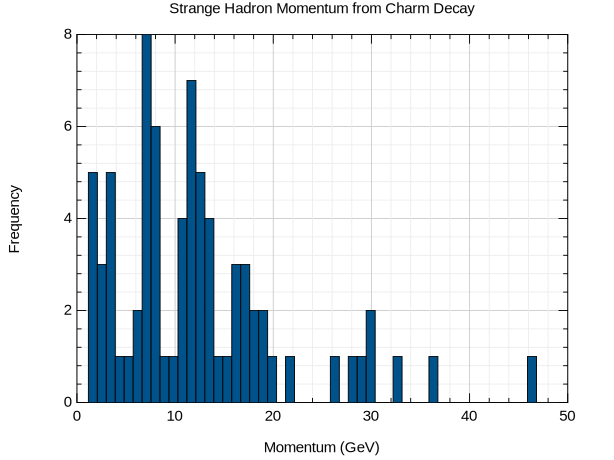

In [11]:
#histogram of momentum for final state strange hadrons from higgs to charm decay
histogram(totalMomenta,nbins=50, 
    title = "Strange Hadron Momentum from Charm Decay", xlabel = "Momentum (GeV)", ylabel = "Frequency")

In [12]:
#tabulate bottom quark decays (whether its a strange hadron or not, this code is better implemented in the momentum_histograms file)

#find all hadrons (stable or unstable) who come originally from higgs to charm decay

totalMomenta2 = []
function findHadrons2(particle)
    total_list = []
    daughter_list = [p for p in getDaughters(particle)[]]
    if getPDG(particle)>99
        push!(total_list,(getPDG(particle),norm(getMomentum(particle)), getGeneratorStatus(particle)))
    end
    if length(daughter_list)==0
        return total_list
    end
    for x in daughter_list
        if getGeneratorStatus(x)==1 && getPDG(x)>99
            #println("here")
            push!(total_list,(getPDG(x),norm(getMomentum(x)), getGeneratorStatus(x)))
        else
            return findHadrons2(x)
        end
    end
    return total_list
end

#find strange hadrons
function findstrange(count_dict,len)
    println(len)
    total_strange = 0
    strange_mesons = 0
    strange_baryons = 0
    other_strange = 0
    other = 0
    for (key,value) in count_dict
        key_string = string(abs(key))
        if key_string[1]=='3' || key_string == "130"
            total_strange+=value
            if length(key_string)==3
                strange_mesons+=value
            elseif length(key_string)==4
                strange_baryons+=value
            else
                other_strange+=value
            end
        end
    end
    other = len - total_strange
    stringlist = ["strange hadrons","strange mesons","strange baryons","other_strange","other particles"]
    problist = []
    push!(problist,(total_strange,sqrt(total_strange)))
    push!(problist,(strange_mesons,sqrt(strange_mesons)))
    push!(problist,(strange_baryons,sqrt(strange_baryons)))
    push!(problist,(other_strange,sqrt(other_strange)))
    push!(problist,(other,sqrt(other)))
    dw = DataFrame(x = stringlist, y = problist)
    table(dw)
end

#reading the file and calling helper functions
LCIO.open("E250-TDR_ws.Pe2e2h.Gwhizard-1_95.eL.pR.I106479.001.slcio") do reader
    totalparticlearray = []
    number_events = 0
    for event in reader
        for particle in getCollection(event, "MCParticle")
            pt = getParents(particle)
            parent = [p for p in pt[]]
            parentPDG=0
            if length(parent) > 0
                parentPDG = getPDG(parent[1])
            end
            
            if abs(parentPDG) == 5
                
                parent2 = [q for q in getParents(pt[1])[]]
                parent2PDG=0
                if length(parent2) > 0
                    parent2PDG = getPDG(parent2[1])
                end
                if parent2PDG == 25
                    number_events+=1
                    push!(totalparticlearray,findHadrons2(particle))
                end
                
            end
        end
    end

#construct data table (not strange specific)
    totalparticlearray = collect(Iterators.flatten(totalparticlearray))
    totalPDG = [] 
    for x in totalparticlearray
        push!(totalPDG, x[1])
        a = string(x[1])
        if (a[1] == '3' || a == "130") && x[3]==1
            push!(totalMomenta2, x[2])
        end
    end
    #println(totalparticlearray)
    total_events = number_events
    #println(total_events)
    x=countmap(totalPDG)
    #println("The total particle distribution: ", x)
    y = length(totalPDG)
    println("There are $(y) hadrons")
    newdict = Dict()
    for (key,value) in x
        newdict[key] = value/y
    end
    #println(newdict)
    PDGValues = []
    Prob = []
    for (key,value) in newdict
        push!(PDGValues, key)
        push!(Prob,(value, sqrt(value*y)/total_events))
    end
    #println(PDGValues)
    df = DataFrame(x = PDGValues, y = Prob)
    table(df) #super large, but not sure why it doesn't show
    #strange-specific data table
    findstrange(x,y)
end

There are 1673 hadrons
1673


Table with 5 rows, 2 columns:
x                  y
──────────────────────────────────
"strange hadrons"  (1618, 40.2244)
"strange mesons"   (1613, 40.1622)
"strange baryons"  (5, 2.23607)
"other_strange"    (0, 0.0)
"other particles"  (55, 7.4162)

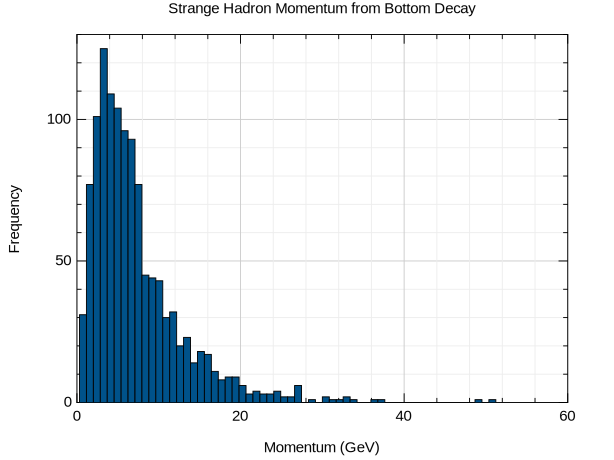

In [14]:
#histogram of momentum for final state strange hadrons from higgs to bottom decay
histogram(totalMomenta2, nbins = 60,
    title = "Strange Hadron Momentum from Bottom Decay", xlabel = "Momentum (GeV)", ylabel = "Frequency")